# Surface water segmentation



## Environment

Install `torchgeo`, `rasterio`, and `rioxarray` libraries.

In [1]:
%pip install -q torchgeo rasterio rioxarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.5/292.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 61.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 56.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 653.4/653.4 kB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 84.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 88.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 34.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Data

<!-- ![Image](https://raw.githubusercontent.com/xinluo2018/WatNet/main/figures/dataset.png) -->

The [Earth Surface Water Dataset](https://zenodo.org/record/5205674) (Luo 2021) contains 95 Sentinel-2 scenes &ndash; and corresponding water masks &ndash; from all over the world. For example:

|||
|--|--|
|![example_1](https://raw.githubusercontent.com/xinluo2018/WatNet/main/figures/label_sam_1.png)|![example_2](https://raw.githubusercontent.com/xinluo2018/WatNet/main/figures/label_sam_2.png)|


The dataset is partitioned into training (`tra_*`) and validation (`val_*`) sets. We'll download and unpack the archive below.

In [2]:
!wget -nc https://zenodo.org/record/5205674/files/dset-s2.zip

--2023-06-20 22:51:58--  https://zenodo.org/record/5205674/files/dset-s2.zip
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 611792578 (583M) [application/octet-stream]
Saving to: ‘dset-s2.zip’

dset-s2.zip         100%[===================>] 583.45M  14.9MB/s    in 42s     

2023-06-20 22:52:42 (13.9 MB/s) - ‘dset-s2.zip’ saved [611792578/611792578]



In [3]:
!unzip -qn dset-s2.zip


### An aside | open a sample

In [4]:
from pathlib import Path
import rioxarray
import matplotlib.pyplot as plt

root = Path('dset-s2')
assert root.exists()

train_imgs = list((root/'tra_scene').glob('*.tif'))
train_masks = list((root/'tra_truth').glob('*.tif'))

train_imgs.sort(); train_masks.sort() # mages and corresponding masks are matched by name

In [5]:
idx = 0
img = rioxarray.open_rasterio(train_imgs[idx])
mask = rioxarray.open_rasterio(train_masks[idx])

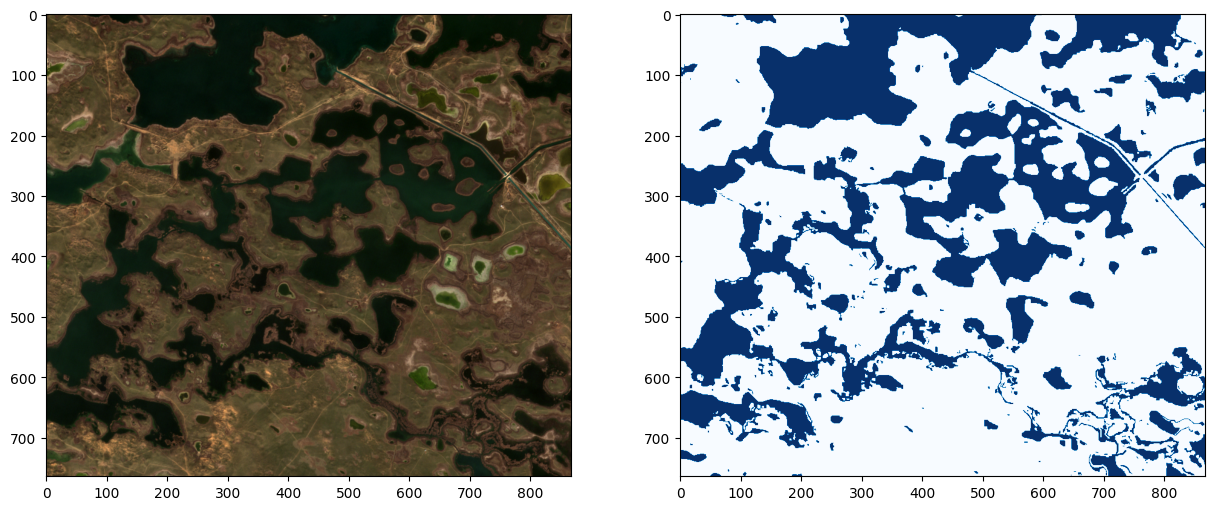

In [6]:
_, axs = plt.subplots(1, 2, figsize=(15, 6))

# plot the tile
rgb = img.data[[2, 1, 0]].transpose((1, 2, 0))/3000
axs[0].imshow(rgb.clip(min=0, max=1))

# plot the mask
axs[1].imshow(mask.data.squeeze(), cmap='Blues')

## Imports

In [7]:
from pathlib import Path
from typing import Iterable, List
import matplotlib.pyplot as plt

import rasterio as rio

from torchgeo.datasets import RasterDataset, unbind_samples, stack_samples
from torchgeo.samplers import RandomGeoSampler, Units
from torchgeo.transforms import indices
from torch.utils.data import DataLoader
import torch

import logging


In [8]:
logger = logging.getLogger("rasterio")
logger.setLevel(logging.ERROR)

In [9]:
root = Path('dset-s2')
assert root.exists()

## Creating the datasets

Prepare the data to be loaded into a neural network using an instance of TorchGeo's `RasterDataset` class. We use World Mercator (`EPSG:3395`) as the common Coordinate Reference System (CRS). The `scale` function applies the normalization required to get reflectances. We combine images with masks (labels) using the `&` operator.

The training samples we'll feed into the neural network from our dataset need to be a fixed size. We use the `RandomGeoSampler` class to select random bounding boxes (of fixed size) from the original scenes. These bounding boxes are used in turn by `RasterDataset` to query portions of the original images.

In [10]:
def scale(item: dict):
    item['image'] = item['image'] / 10000
    return item

In [11]:
train_imgs = RasterDataset(root=(root/'tra_scene').as_posix(), crs='EPSG:3395', res=10, transforms=scale)
train_msks = RasterDataset(root=(root/'tra_truth').as_posix(), crs='EPSG:3395', res=10)

valid_imgs = RasterDataset(root=(root/'val_scene').as_posix(), crs='EPSG:3395', res=10, transforms=scale)
valid_msks = RasterDataset(root=(root/'val_truth').as_posix(), crs='EPSG:3395', res=10)

train_msks.is_image = False  # our masks are not "images"
valid_msks.is_image = False

train_dset = train_imgs & train_msks  # create the IntersectionDataset
valid_dset = valid_imgs & valid_msks

train_sampler = RandomGeoSampler(train_imgs, size=512, length=130, units=Units.PIXELS)
valid_sampler = RandomGeoSampler(valid_imgs, size=512, length=64, units=Units.PIXELS)


The `size` parameter controls the shape of a training or validation sample (in this case 512x512 pixels), while `length` is the number of samples we'll use per epoch in each phase (model training and validation).

### An aside | understanding the sampler

To draw a random sample from the dataset, call the sampler for one bounding box and then pass this bounding box to the dataset. The result will be a dictionary with the following entries: `crs`, `bbox`, `image`, and `mask`.

In [12]:
bbox = next(iter(train_sampler))
bbox

BoundingBox(minx=-6242962.824186995, maxx=-6237842.824186995, miny=6245608.515680029, maxy=6250728.515680029, mint=0.0, maxt=9.223372036854776e+18)

In [13]:
sample = train_dset[bbox]
sample.keys()

dict_keys(['crs', 'bbox', 'image', 'mask'])

In [14]:
sample['image'].shape, sample['mask'].shape

(torch.Size([6, 512, 512]), torch.Size([1, 512, 512]))

Here 👆 we see our 512x512 pixel images have 6 spectral channels

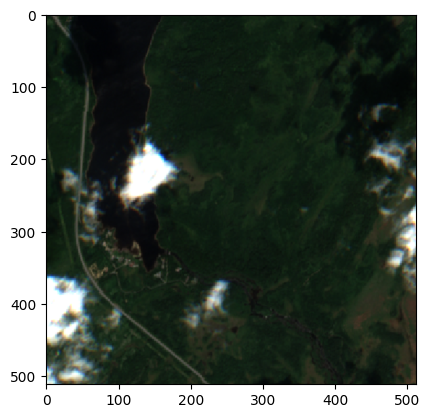

In [18]:
arr = torch.clamp(sample['image'], min=0, max=1).numpy()
rgb = arr.transpose(1, 2, 0)[:, :, [2, 1 , 0]]

plt.imshow(rgb*3)  # the 3x here just increases brightness

## Creating data loaders

Use the dataset and samplers defined above to create a `DataLoader`, with `batch_size` (the number of samples in each batch) set to 8. The collate function specifies how to concatenate multiple individual samples into a single batch.

In [19]:
train_dataloader = DataLoader(train_dset, sampler=train_sampler, batch_size=8, collate_fn=stack_samples)
valid_dataloader = DataLoader(valid_dset, sampler=valid_sampler, batch_size=8, collate_fn=stack_samples)

### An aside | visualizing batches

We can iterate through the data loader to grab batches from it. To test it, we will get the first batch.

In [30]:
train_batch = next(iter(train_dataloader))
valid_batch = next(iter(valid_dataloader))
print(train_batch.keys())
train_batch['image'].shape, train_batch['mask'].shape

dict_keys(['crs', 'bbox', 'image', 'mask'])


(torch.Size([8, 6, 512, 512]), torch.Size([8, 1, 512, 512]))

Create a function to display the batches.

The function, `plot_batch`, checks the number of items in the batch and &ndash; if there are masks associated &ndash; arranges the output grid accordingly.

In [21]:
from typing import Iterable, List, Optional, Callable
import torch

def plot_imgs(images: Iterable, axs: Iterable, chnls: List[int] = [2, 1, 0], bright: float = 3.):
    for img, ax in zip(images, axs):
        arr = torch.clamp(bright * img, min=0, max=1).numpy()
        rgb = arr.transpose(1, 2, 0)[:, :, chnls]
        ax.imshow(rgb)
        ax.axis('off')


def plot_msks(masks: Iterable, axs: Iterable):
    for mask, ax in zip(masks, axs):
        ax.imshow(mask.squeeze().numpy(), cmap='Blues')
        ax.axis('off')

def plot_batch(batch: dict, bright: float = 3., cols: int = 4, width: int = 5, chnls: List[int] = [2, 1, 0]):

    # Get the samples and the number of items in the batch
    samples = unbind_samples(batch.copy())

    # if batch contains images and masks, the number of images will be doubled
    n = 2 * len(samples) if ('image' in batch) and ('mask' in batch) else len(samples)

    # calculate the number of rows in the grid
    rows = n//cols + (1 if n%cols != 0 else 0)

    # create a grid
    _, axs = plt.subplots(rows, cols, figsize=(cols*width, rows*width))

    if ('image' in batch) and ('mask' in batch):
        # plot the images on the even axis
        plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1)[::2], chnls=chnls, bright=bright)

        # plot the masks on the odd axis
        plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1)[1::2])

    else:

        if 'image' in batch:
            plot_imgs(images=map(lambda x: x['image'], samples), axs=axs.reshape(-1), chnls=chnls, bright=bright)

        elif 'mask' in batch:
            plot_msks(masks=map(lambda x: x['mask'], samples), axs=axs.reshape(-1))

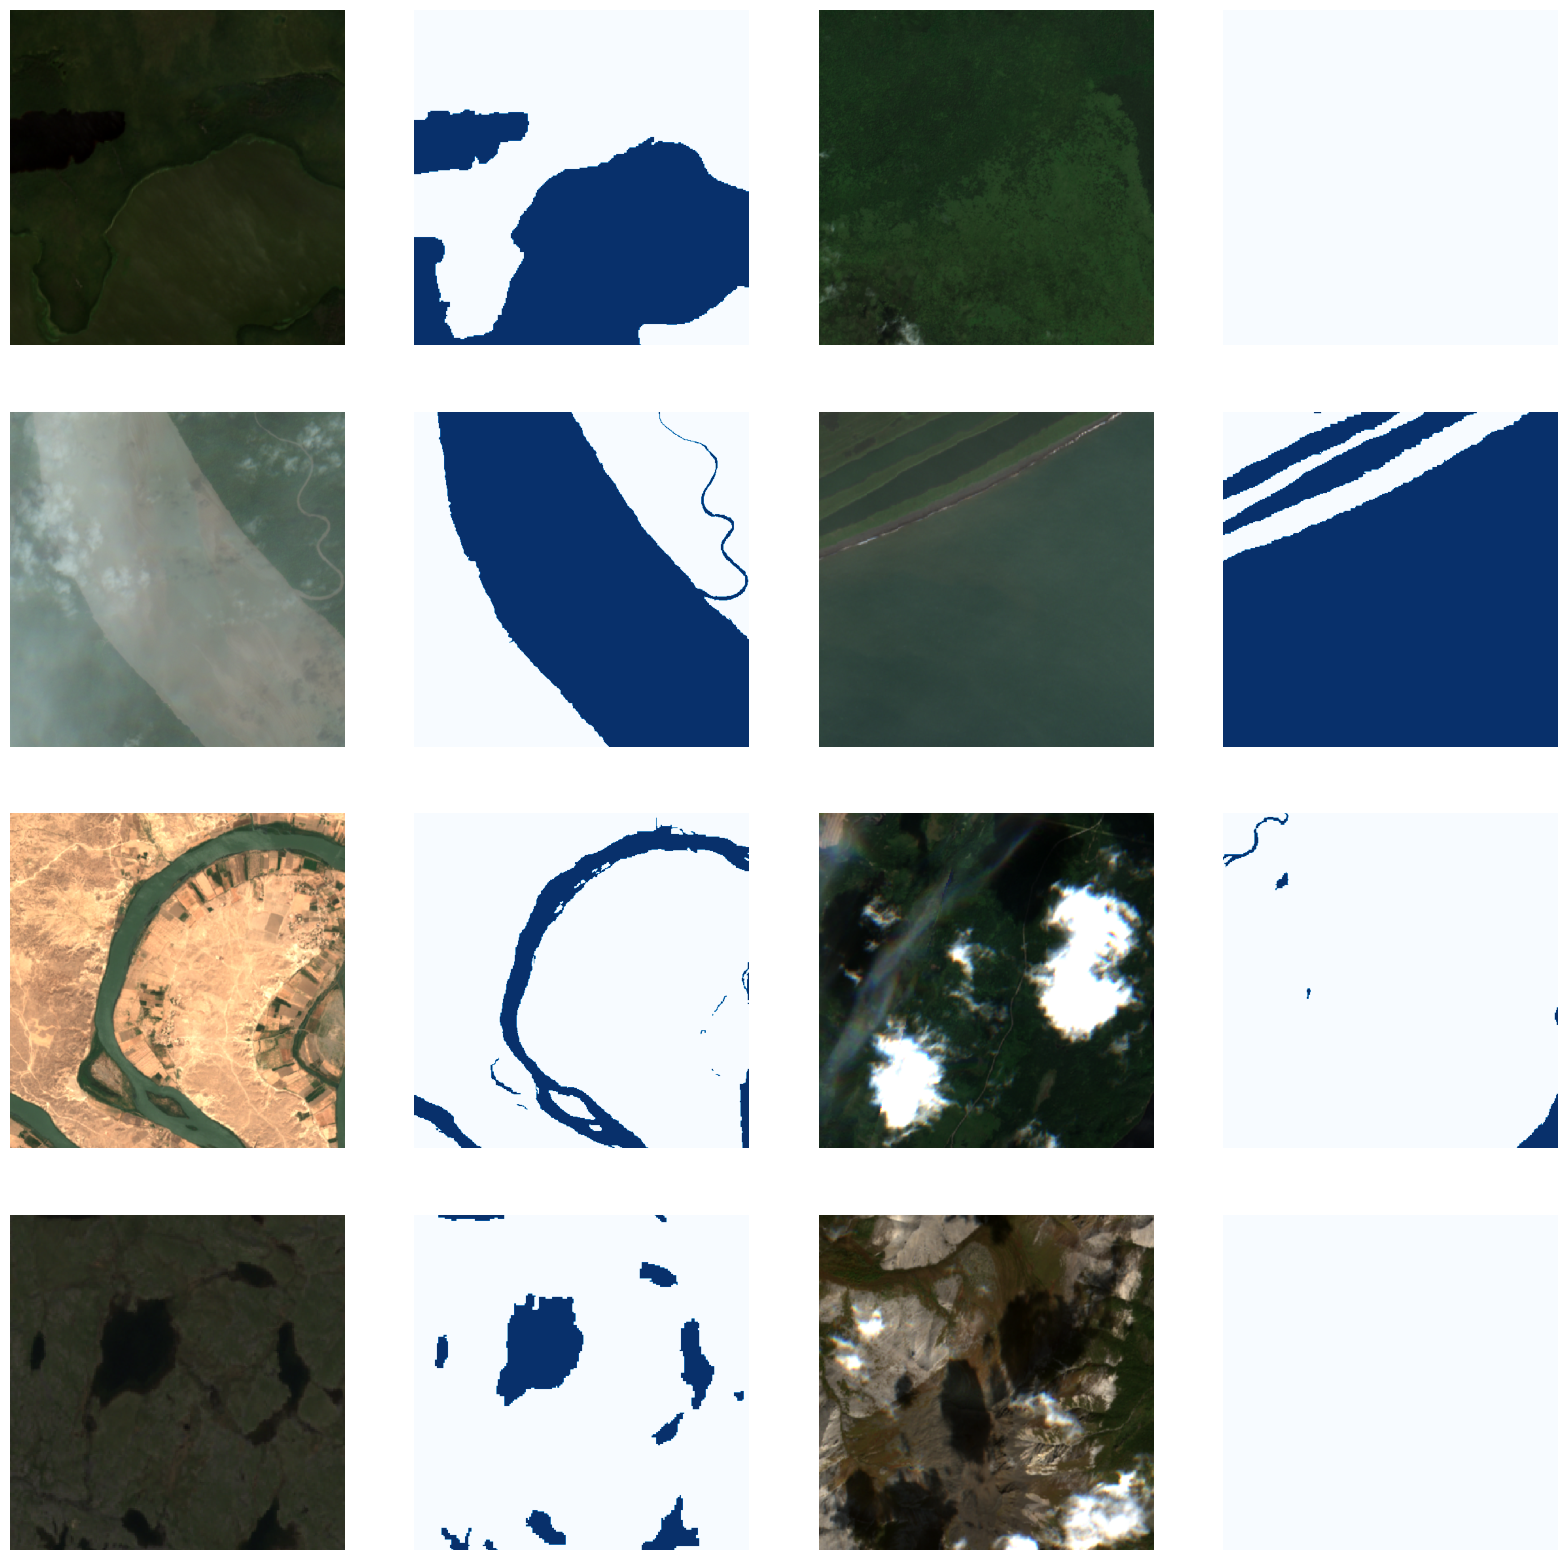

In [22]:
plot_batch(train_batch)

## Data standardization

We'll scale each channel to zero mean and unit variance. To do that, we need to first find the mean and standard deviation for each one of the 6 channels in the dataset.

We define a function calculate these statistics and write its results in the variables `mean` and `std`.

In [23]:
def calc_statistics(dset: RasterDataset):
        """
        Calculate the statistics (mean and std) for the entire dataset
        Warning: This is an approximation. The correct value should take into account the
        mean for the whole dataset for computing individual stds.
        For correctness I suggest checking: http://notmatthancock.github.io/2017/03/23/simple-batch-stat-updates.html
        """

        # To avoid loading the entire dataset in memory, we will loop through each img
        # The filenames will be retrieved from the dataset's rtree index
        files = [item.object for item in dset.index.intersection(dset.index.bounds, objects=True)]

        # Reseting statistics
        accum_mean = 0
        accum_std = 0

        for file in files:
            img = rio.open(file).read()/10000 #type: ignore
            accum_mean += img.reshape((img.shape[0], -1)).mean(axis=1)
            accum_std += img.reshape((img.shape[0], -1)).std(axis=1)

        # at the end, we shall have 2 vectors with lenght n=chnls
        # we will average them considering the number of images
        return accum_mean / len(files), accum_std / len(files)

In [24]:
mean, std = calc_statistics(train_imgs)
print(mean, std)

[0.0771449  0.09890421 0.09758993 0.22216185 0.1854808  0.13288888] [0.04496952 0.05038998 0.06053346 0.10840577 0.0993342  0.08219175]


In [25]:
class Scale(torch.nn.Module):
    def __init__(self, mean: List[float], stdev: List[float]):
        super().__init__()

        self.mean = torch.Tensor(mean)[:, None, None]
        self.std = torch.Tensor(stdev)[:, None, None]

    def forward(self, inputs: dict):

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if inputs["image"].ndim == 4:
            x = (x - self.mean[None, ...]) / self.std[None, ...]

        else:
            x = (x - self.mean) / self.std

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

    def revert(self, inputs: dict):
        """
        De-normalize the batch.

        Args:
            inputs (dict): Dictionary with the 'image' key
        """

        x = inputs["image"][..., : len(self.mean), :, :]

        # if batch
        if x.ndim == 4:
            x = inputs["image"][:, : len(self.mean), ...]
            x = x * self.std[None, ...] + self.mean[None, ...]
        else:
            x = x * self.std + self.mean

        inputs["image"][..., : len(self.mean), :, :] = x

        return inputs

class AppendNormalizedIndices(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inputs: dict):

        x = inputs["image"]

        ndwi_transform = indices.AppendNDWI(index_green=1, index_nir=3)
        mndwi_transform = indices.AppendNDWI(index_green=1, index_nir=5)
        ndvi_transform = indices.AppendNDVI(index_nir=3, index_red=2)

        x = ndwi_transform(x)
        x = mndwi_transform(x)
        x = ndvi_transform(x)

        inputs["image"] = x

        return inputs

### An aside | check that we can scale and unscale images

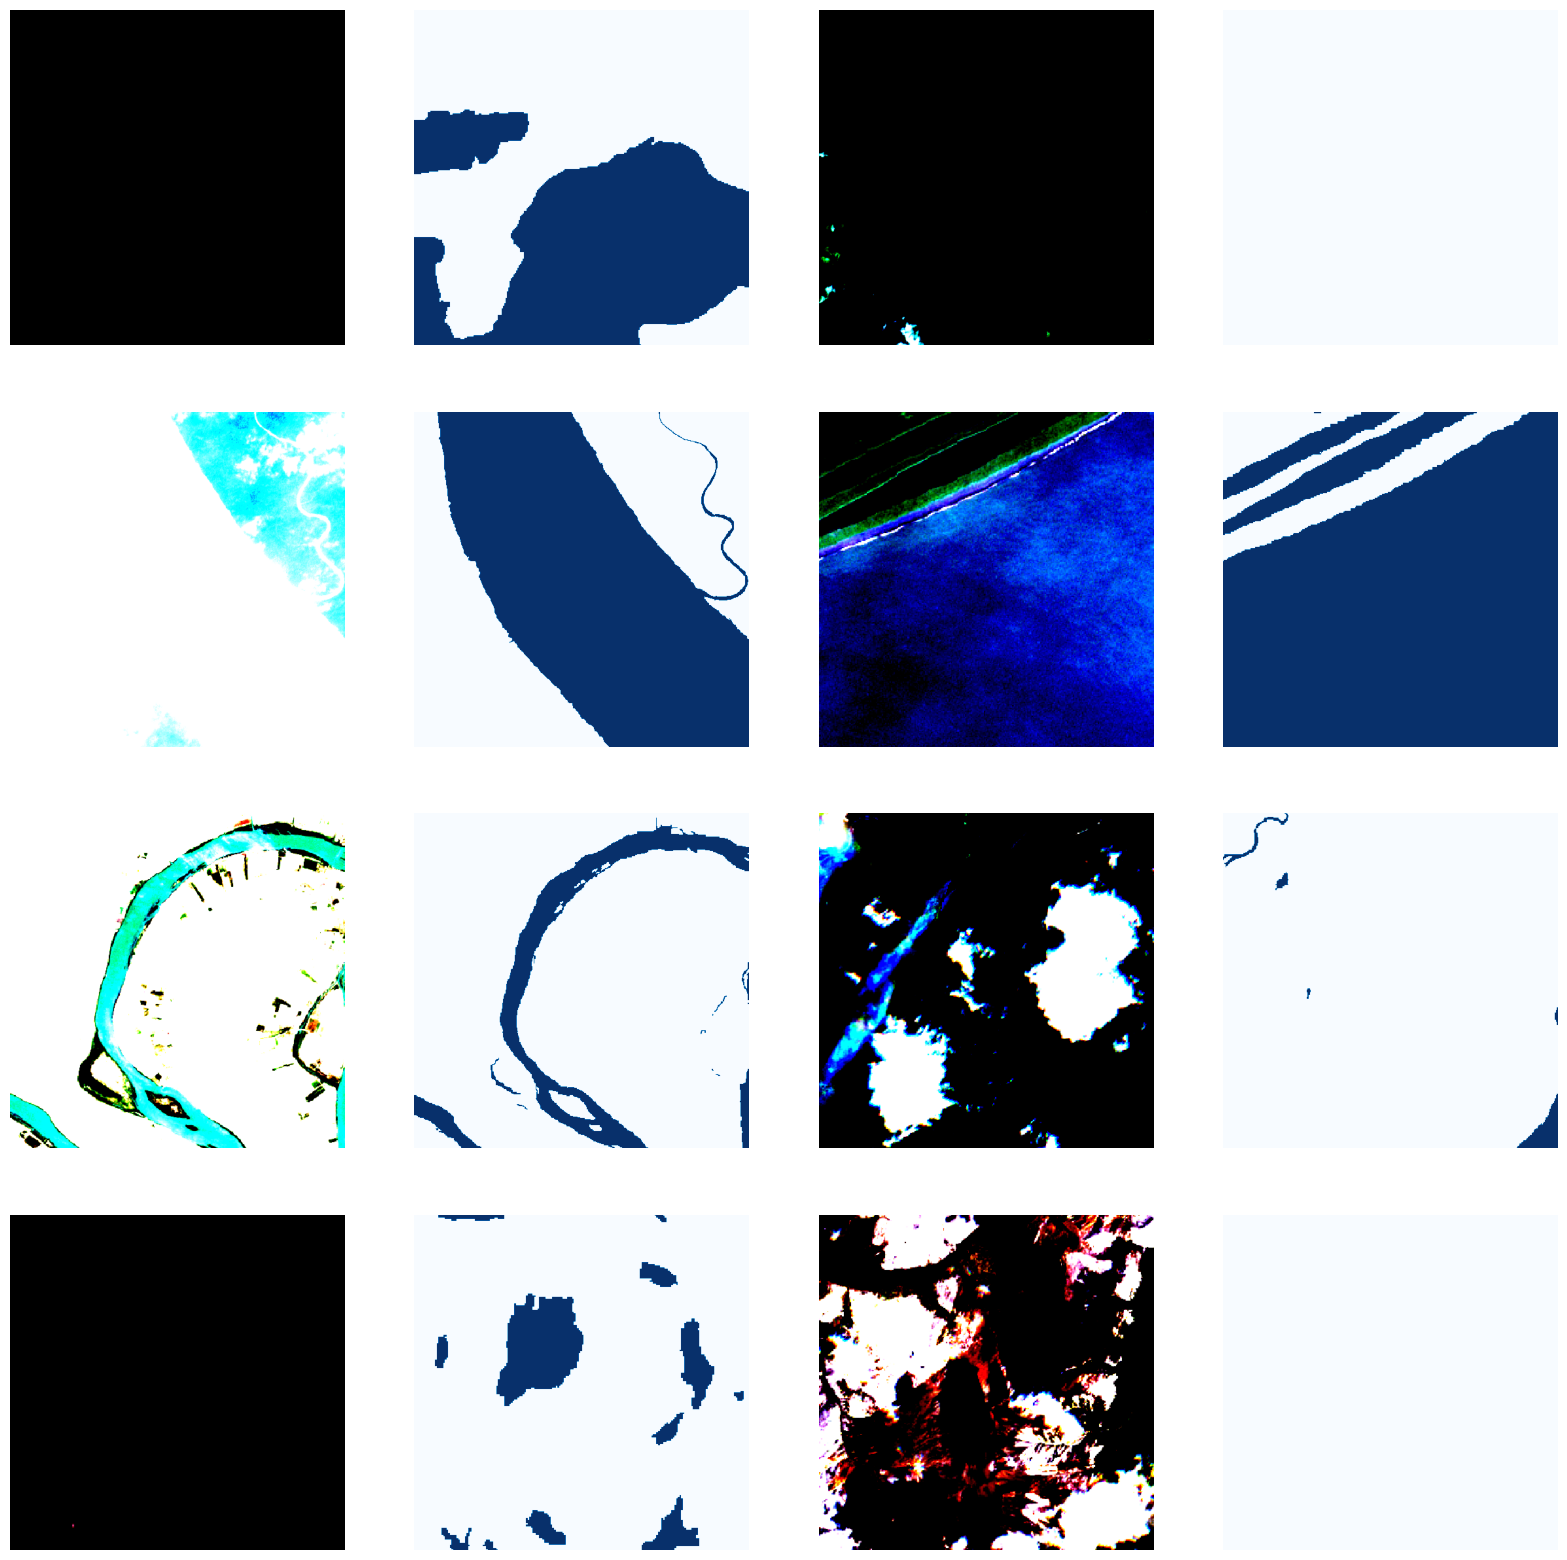

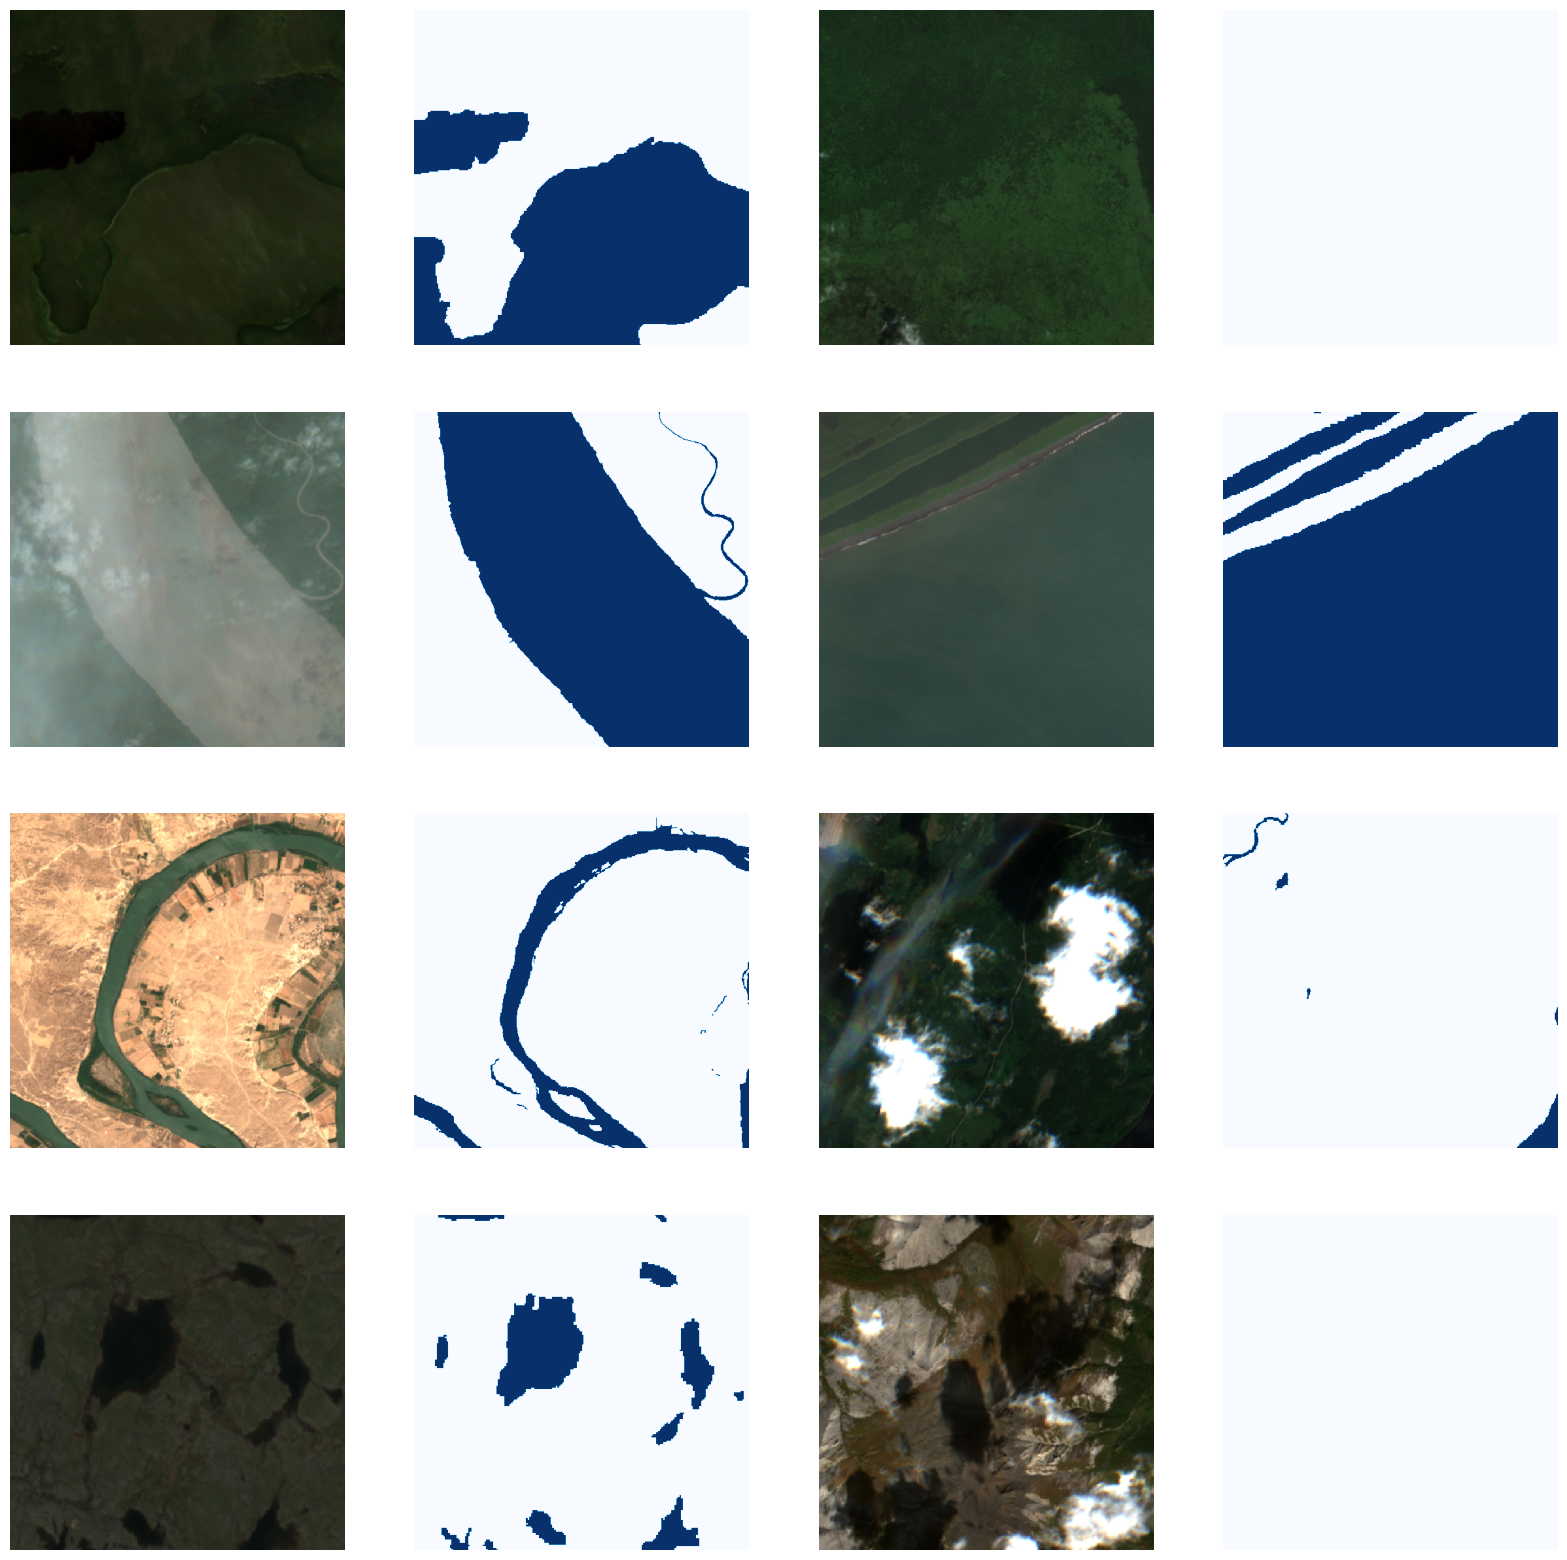

In [26]:
normalize = Scale(mean=mean, stdev=std)
norm_batch = normalize(train_batch)
plot_batch(norm_batch)

batch = normalize.revert(norm_batch)
plot_batch(batch)

In [27]:
normalize = Scale(*calc_statistics(train_imgs))
append_indices = AppendNormalizedIndices()

tfms = torch.nn.Sequential(
    append_indices,
    normalize
)

In [31]:
final_transformed_batch = tfms(train_batch)
print(train_batch['image'].shape)  # caution: the train batch is modified in place
final_transformed_batch['image'].shape, final_transformed_batch['mask'].shape

torch.Size([8, 9, 512, 512])


(torch.Size([8, 9, 512, 512]), torch.Size([8, 1, 512, 512]))

Our transformed batch now has 9 channels (the original 6 + three normalized difference indices).

> Important: the normalize method we created will apply the normalization just to the original bands and it will ignore the previously appended indices. That’s important to avoid errors due to distinct shapes between the batch and the `mean` and `std` vectors.

torch.Size([9, 512, 512])


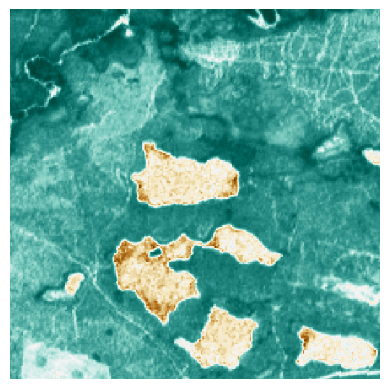

In [32]:
image = final_transformed_batch['image'][0]
print(image.shape)

# Normalize from [-1, 1] -> [0, 1] for visualization
image[-1] = (image[-1] + 1) / 2

plt.imshow(image[-1], cmap="BrBG")
plt.axis("off")
plt.show()
plt.close()

In [33]:
channels = final_transformed_batch['image'].shape[1]

In [34]:
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.double_conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownBlock, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels)
        self.down_sample = nn.MaxPool2d(2)

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_out = self.down_sample(skip_out)
        return (down_out, skip_out)


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, up_sample_mode):
        super(UpBlock, self).__init__()
        if up_sample_mode == 'conv_transpose':
            self.up_sample = nn.ConvTranspose2d(in_channels-out_channels, in_channels-out_channels, kernel_size=2, stride=2)
        elif up_sample_mode == 'bilinear':
            self.up_sample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            raise ValueError("Unsupported `up_sample_mode` (can take one of `conv_transpose` or `bilinear`)")
        self.double_conv = DoubleConv(in_channels, out_channels)

    def forward(self, down_input, skip_input):
        x = self.up_sample(down_input)
        x = torch.cat([x, skip_input], dim=1)
        return self.double_conv(x)


class UNet(nn.Module):
    def __init__(self, n_bands=3, out_classes=2, up_sample_mode='conv_transpose'):
        super(UNet, self).__init__()
        self.up_sample_mode = up_sample_mode
        # Downsampling Path
        self.down_conv1 = DownBlock(n_bands, 64)
        self.down_conv2 = DownBlock(64, 128)
        self.down_conv3 = DownBlock(128, 256)
        self.down_conv4 = DownBlock(256, 512)
        # Bottleneck
        self.double_conv = DoubleConv(512, 1024)
        # Upsampling Path
        self.up_conv4 = UpBlock(512 + 1024, 512, self.up_sample_mode)
        self.up_conv3 = UpBlock(256 + 512, 256, self.up_sample_mode)
        self.up_conv2 = UpBlock(128 + 256, 128, self.up_sample_mode)
        self.up_conv1 = UpBlock(128 + 64, 64, self.up_sample_mode)
        # Final Convolution
        self.conv_last = nn.Conv2d(64, out_classes, kernel_size=1)

    def forward(self, x):
        x, skip1_out = self.down_conv1(x)
        x, skip2_out = self.down_conv2(x)
        x, skip3_out = self.down_conv3(x)
        x, skip4_out = self.down_conv4(x)
        x = self.double_conv(x)
        x = self.up_conv4(x, skip4_out)
        x = self.up_conv3(x, skip3_out)
        x = self.up_conv2(x, skip2_out)
        x = self.up_conv1(x, skip1_out)
        x = self.conv_last(x)
        return x


# Get UNet model
model = UNet(n_bands=channels, out_classes=2)

### An aside | check that the model produces the expected output dimensions

In [35]:
pred = model(torch.randn(3, 9, 512, 512))
pred.shape
# pred['out'].shape

torch.Size([3, 2, 512, 512])

Given the model architecture, the same should also work in eval mode when we supply a much larger image!

In [36]:
model(torch.randn(1, 9, 1024, 1024)).shape

torch.Size([1, 2, 1024, 1024])

In [38]:
import time
import numpy as np

def train(
    model: torch.nn.Module,
    train_dl: DataLoader,
    valid_dl: Optional[DataLoader],
    loss_fn: Callable,
    optimizer: torch.optim.Optimizer,
    acc_fn: Callable,
    # acc_fns: Optional[List]=None,
    transforms: Optional[Callable]=None,
    epochs: int=1,
):
    # size = len(dataloader.dataset)
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    for epoch in range(epochs):

        print(f'Epoch {epoch}/{epochs - 1}')
        print('-' * 10)

        phases = ['train', 'valid'] if valid_dl is not None else ['train']
        for phase in phases:
            if phase == 'train':
                model.train(True)  # train mode
                dataloader = train_dl
            else:
                model.train(False)  # evaluate mode
                dataloader = valid_dl

            running_acc = 0.0  # [0.0] * len(acc_fns)
            running_loss = 0.0

            step = 0

            # iterate over the data
            for batch in dataloader:

                step += 1

                if transforms is not None:
                    batch = transforms(batch)

                X = batch['image'].cuda()
                y = batch['mask'].type(torch.long).cuda()

                if phase == 'train':
                    # forward pass
                    optimizer.zero_grad()  # zero the gradients
                    pred = model(X)
                    loss = loss_fn(pred, y)

                    # backward pass
                    loss.backward()
                    optimizer.step()

                else:
                    with torch.no_grad():
                        pred = model(X)
                        loss = loss_fn(pred, y)

                # stats - whatever the phase
                # if acc_fns is not None:
                #     for i, acc_fn in enumerate(acc_fns):
                #         acc = acc_fn(pred, y)
                #         running_acc[i] += acc*dataloader.batch_size
                acc = acc_fn(pred, y)
                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size

                print(f'Current step: {step}  Loss: {loss}  Acc: {acc}')

            epoch_acc = running_acc / len(dataloader.dataset)  # [z / len(dataloader.dataset) for z in running_acc]
            epoch_loss = running_loss / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc}')  # ["%.3f" % z for z in epoch_acc]
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return torch.tensor(train_loss, device='cpu'), torch.tensor(valid_loss, device='cpu')

In [ ]:
# print(len(train_dataloader.dataset), len(valid_dataloader.dataset))
# train_dataloader.batch_size, valid_dataloader.batch_size

# Steps per Epoch = (Total Number of Training Samples) / (Batch Size)

In [44]:
# from sklearn.metrics import jaccard_score
from torchmetrics import JaccardIndex

def oa(pred, y):
    """Overall accuracy"""
    flat_y = y.squeeze()
    flat_pred = pred.argmax(dim=1)
    acc = torch.count_nonzero(flat_y == flat_pred) / torch.numel(flat_y)
    return acc

# def iou(pred, y):
#     """Intersection over Union"""
#     flat_y = y.cpu().numpy().squeeze()
#     flat_pred = pred.argmax(dim=1).detach().cpu().numpy()
#     return jaccard_score(flat_y.reshape(-1), flat_pred.reshape(-1), zero_division=1.)

jaccard = JaccardIndex(task="multiclass", num_classes=2)
def iou(pred, y):
    """Intersection over Union"""
    flat_pred = pred.argmax(dim=1)
    return jaccard(flat_pred, y)

def loss(p, t):
    return torch.nn.functional.cross_entropy(p, t.squeeze())

In [45]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)
train_loss, valid_loss = train(
    model, train_dataloader, valid_dataloader, loss, optimizer,
    acc_fn = iou, # acc_fns=[oa, iou],
    transforms=tfms,
    epochs=1
)

Epoch 0/0
----------


ValueError: ignored

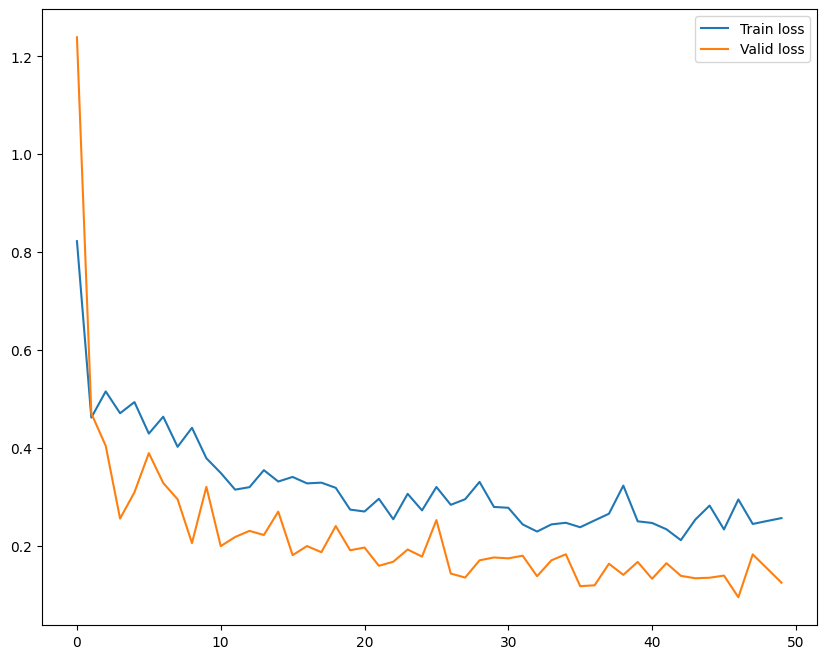

In [ ]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [ ]:
def batch_to_img(batch_raw, idx):
  arr = torch.clamp(batch_raw['image'][idx, 0:3], min=0, max=1).numpy()
  rgb = arr.transpose(1, 2, 0)[:, :, [2, 1, 0]]
  return rgb

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [ ]:
# xb, yb = next(iter(train_dl))
eval_batch = next(iter(valid_dataloader))
eval_batch_raw = normalize.revert(eval_batch)
eval_batch_transformed = tfms(eval_batch)

Xb = eval_batch_transformed['image'].cuda()
yb = eval_batch['mask'] #.type(torch.long).cuda()

with torch.no_grad():
    predb = model(Xb)

predb.shape

torch.Size([8, 2, 512, 512])

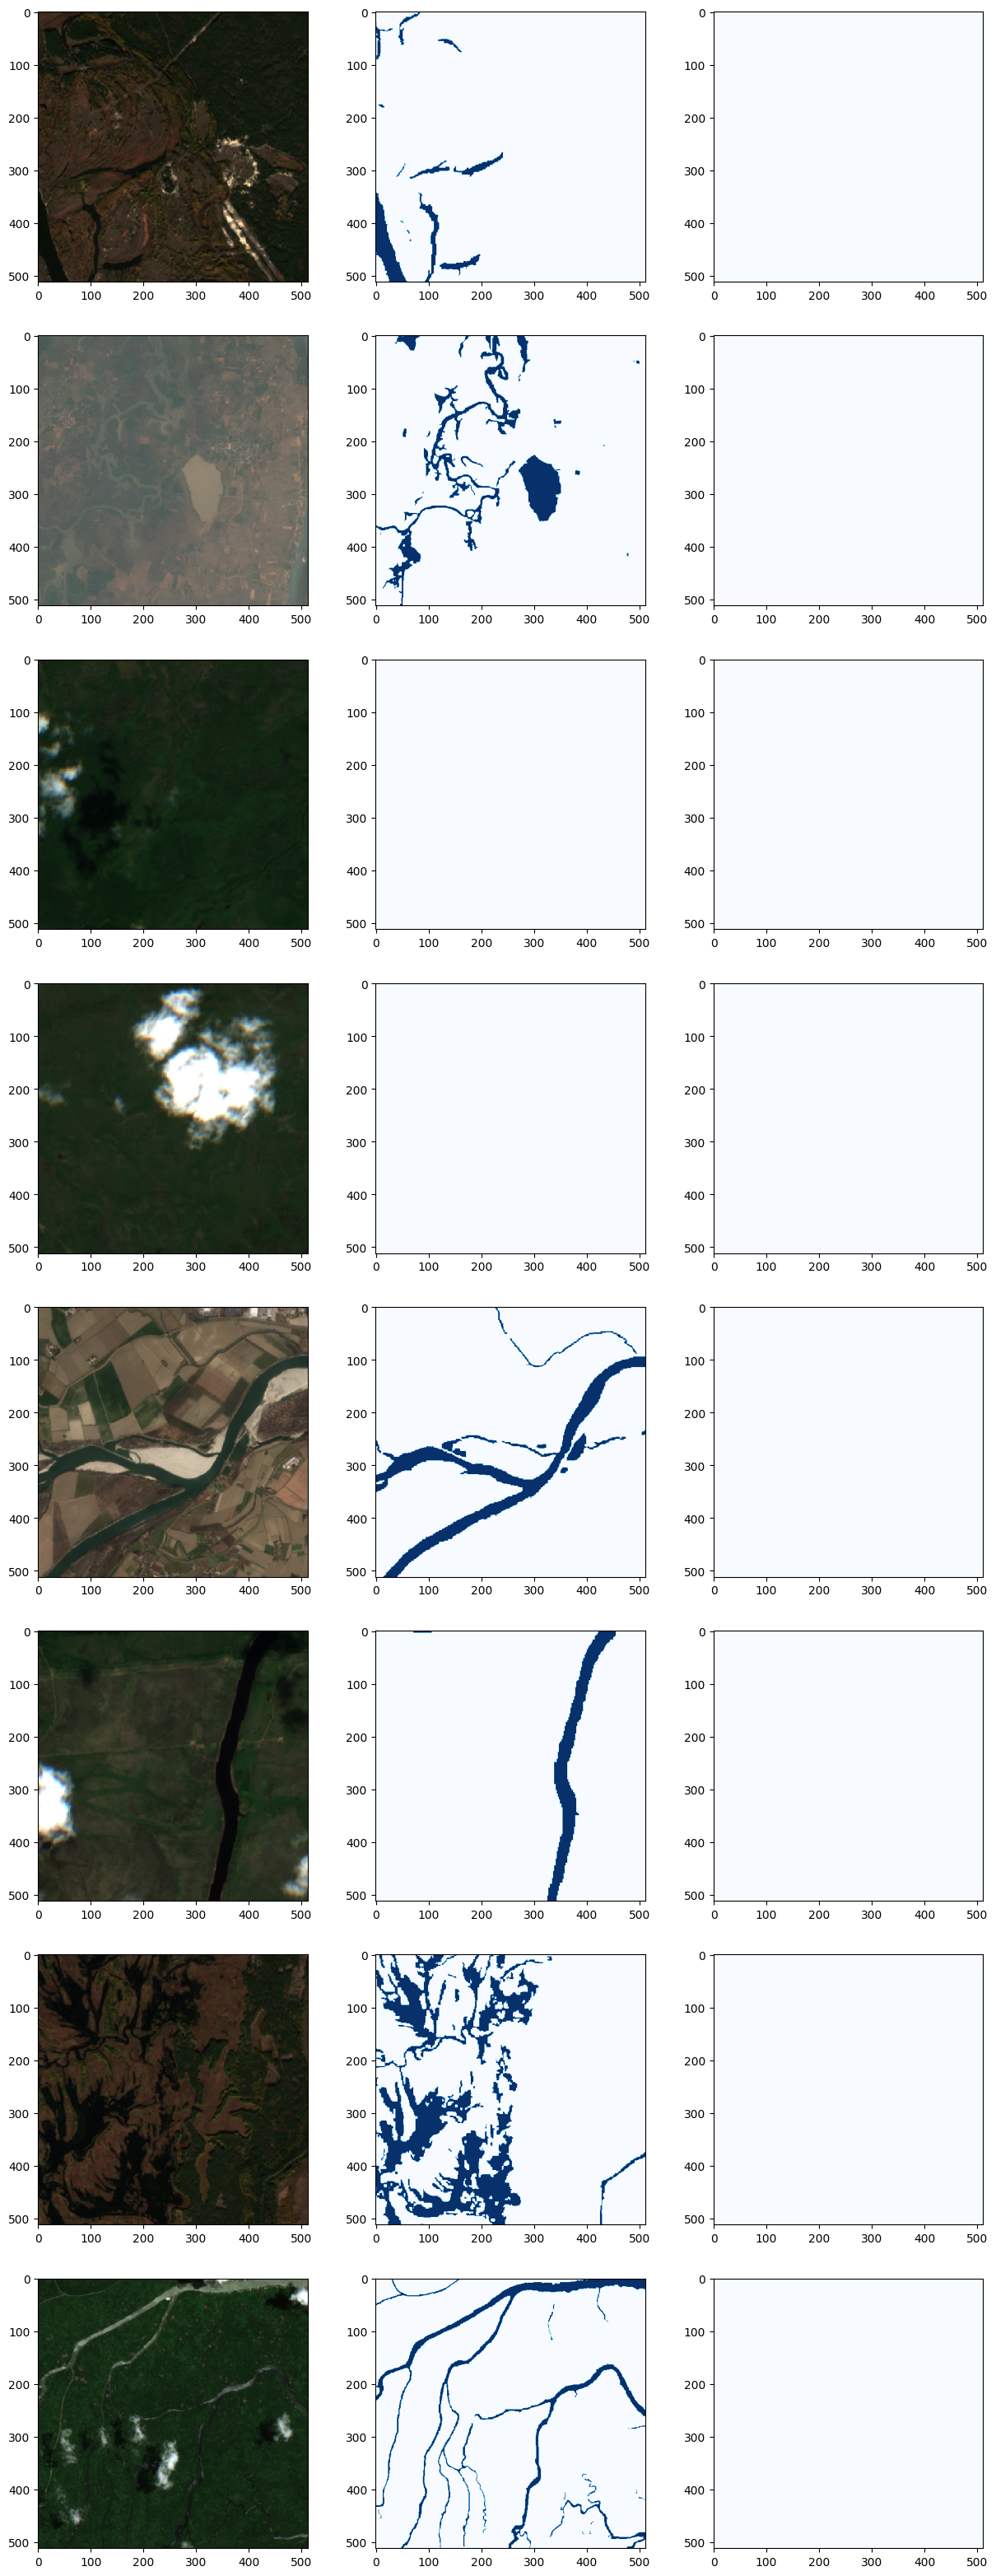

In [ ]:
bs = valid_dataloader.batch_size
fig, ax = plt.subplots(bs, 3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(eval_batch_raw, i)*3)
    ax[i,1].imshow(yb[i].squeeze(), cmap='Blues')
    # ax[i,1].imshow(mask.squeeze().numpy(), cmap='Blues')
    ax[i,2].imshow(predb_to_mask(predb, i), cmap='Blues')